# SIM-LBEG-SCAN-PV
## Used for simulating the effect on the beam of scanning an EPICS PV over some range.
## This is configure for simulating the LBEG beam.

In [1]:
import sys
import os
# define directory to packages and append to $PATH

par_dir = os.path.abspath(os.path.pardir)
print(par_dir)
lib_dir = os.path.join(par_dir,"bin")
print(lib_dir)
sys.path.append(lib_dir)
pkg_dir = os.path.join(par_dir,"pylib")
print(pkg_dir)
sys.path.append(pkg_dir)

#import additional python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# import additional simulation packages
import hpsim as hps
# use next line to select either GPU 0 or 2 on aothpsim
GPU = 0
hps.set_gpu(GPU)
from hpsim import sqldb as pydb
from hpsim import lcsutil as lcs
from hpsim import nputil as nps

/home/echuang/hpsim
/home/echuang/hpsim/bin
/home/echuang/hpsim/pylib
GPU : NVIDIA RTX A6000


In [2]:
################################################################################
# install db's and connect to beamline
db_dir = par_dir + '/db'
lib_dir = par_dir + '/db/lib'
dbs = ['tbtd.db','dtl.db','trst.db','ccl.db']
dbconn1 = hps.DBConnection(db_dir, dbs, lib_dir, 'libsqliteext.so')
dbconn1.print_dbs()
dbconn1.clear_model_index()
print("*** dB connection established ***")

main -> /home/echuang/hpsim/db/tmp/tbtd.db
db1 -> /home/echuang/hpsim/db/tmp/dtl.db
db2 -> /home/echuang/hpsim/db/tmp/trst.db
db3 -> /home/echuang/hpsim/db/tmp/ccl.db
*** dB connection established ***


In [3]:
################################################################################
# create beamline
bl = hps.BeamLine()
beamline = hps.get_element_list()
print("*** Beamline created ***")

*** Beamline created ***


In [4]:
################################################################################
# create table of beamline elements at lengths
pybl = pydb.Db_bl(db_dir, dbs)
py_beamline = pybl.get_bl_elem_len()
print("*** PySQLite Beamline created ***")
for item in py_beamline:
   print("%10.2f %15s %10.5f %10.2f"%(item[0], item[1], item[2], item[3]))


*** PySQLite Beamline created ***
      0.50  b'spch_comp_1'    0.00000       0.00
      1.00       b'TBDR01'    0.05240       0.05
      2.00     b'TBQL01V1'    0.10220       0.15
      3.00       b'TBDR02'    0.05695       0.21
      4.00     b'TBQL01V2'    0.10220       0.31
      5.00       b'TBDR03'    0.05695       0.37
      6.00     b'TBQL01V3'    0.10220       0.47
      7.00       b'TBDR04'    0.11621       0.59
      7.60      b'TBSM01X'    0.00000       0.59
      7.70      b'TBSM01Y'    0.00000       0.59
      8.00       b'TBDR05'    0.08201       0.67
      9.00       b'TBEM01'    0.00000       0.67
      9.20  b'spch_comp_2'    0.00000       0.67
     10.00       b'TBDR06'    0.05903       0.73
     11.00     b'TBQL02V1'    0.10340       0.83
     12.00       b'TBDR07'    0.07273       0.91
     13.00     b'TBQL02V2'    0.10340       1.01
     14.00       b'TBDR08'    0.07273       1.08
     15.00     b'TBQL02V3'    0.10340       1.19
     16.00       b'TBDR09'    0.042

In [5]:
################################################################################
# create H- beam
SIM_START = "TBDB02" #defined by input beam location
#beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*256) #H- beam
beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*128) #H- beam
beam.set_dc(0.095, 47.0, 0.00327,  -0.102, 60.0, 0.002514, 180.0, 0.0, 0.7518) #TBDB02 20140901
beam.set_frequency(201.25)
betalambda = hps.betalambda(mass = beam.get_mass(), freq=beam.get_frequency(), w=0.750)
phi_offset = -hps.get_beamline_length(SIM_START,'BLZ')/betalambda *360
beam.set_ref_w(0.750)
beam.set_ref_phi(phi_offset)
beam.translate('phi', phi_offset)
beam.save_initial_beam()
print("*** H- Beam created ***")
print("at SIM_START = ",SIM_START)


*** H- Beam created ***
at SIM_START =  TBDB02
Beam frequency initialized to 201.25


In [6]:
################################################################################
# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print("spch interval=", spch.get_interval())
print("adj_bunch=", spch.get_adj_bunch())
# define at what energy simulation stops using adjacent bunches in SC calc
spch.set_adj_bunch_cutoff_w(0.8)
# remeshing factor determines how ofter the mesh gets recalc vs scaled for SC kick
spch.set_remesh_threshold(0.02)
#spch.set_remesh_threshold(0.2)
print("cutoff w=", spch.get_adj_bunch_cutoff_w())
print("*** Space Charge Initialized ***")


spch interval= 0.025
adj_bunch= 3
cutoff w= 0.8
*** Space Charge Initialized ***


In [7]:
################################################################################
# create simulator
sim = hps.Simulator(beam)
sim.set_space_charge('on')
print("*** Simulator Initialized ***")


*** Simulator Initialized ***


## Here is where you define the stopping point of the simulations and the energy cutoff value, below which particles are not counted in the results.

In [8]:
################################################################################
# STANDARD AND REQUIRED STUFF ABOVE THIS LINE
################################################################################

print("*** Input Beam ***")
print(SIM_START)
print("w/user units")
beam.print_results()


*** Input Beam ***
TBDB02
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** No Mask applied ***
Number of macroparticles(good) = 131072
Number of macroparticles lost  = 0
Ref part. 
 phi = -40560.1118 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :      -0.0002        0.1600 cm 
xp :       0.0076        3.4265 mr 
y  :       0.0002        0.1587 cm 
yp :       0.0062        2.6524 mr 
phi:  -40560.1090      103.9219 deg
w  :       0.7518        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.0946      0.0469      0.5456     0.02184
y :     -0.1040      0.0602      0.4187     0.01676
z :     -0.0000 20902152.9992      0.0005




## In this section you define the stopping points of the simulations and the energy cutoff. 
## In addition, this is where you define the PV type, scan range, PV area, and beam polarity.
### For example, if I want to scan the main buncher phase and simulate what effect is has on the LBEG beam at the end of DTL Tank 4, I would define the following:

**SIM_STOP = 'TREM01'** # end of tank 4,

**ENERGY_CUTOFF = 95.0 #MeV**; which is somewhat less than the nominal beam output energy of 100 MeV,

**PV_TYPE = 'PHS'** # this tells the routine which PV to connect to, so you don't have to rememeber its name,

**AREA = 'TD'** # since you what so scan the main buncher phase, we select LCS area TD, finally

**BEAM = '-'** # this tells the routine to choose the channel that is tied to that polarity beam.

In [9]:
SIM_STOP = 'TREM01'
ENERGY_CUTOFF = 95.0 #MeV; should be less than the nominal beam output energy
PV_TYPE = 'PHS' #'AMP' or 'PHS' or 'OTHER' or 'NONE'
AREA = 'TD'
BEAM = '-'

if PV_TYPE == 'OTHER':
    # if OTHER then define EPICS_PV here and adjust scan range below
    EPICS_PV = 'MRPH001D01' #master reference phase for whole CCL

if PV_TYPE == None:
    EPICS_PV = None

if PV_TYPE == 'PHS':
# EPICS pv to scan
    EPICS_PV = lcs.get_pv_psp(AREA, beam=BEAM) 
    # Initial pv PHS value; will restore after scan
    PV_INIT_VAL = hps.get_db_epics(EPICS_PV)
    D_PV = 90.0 #degrees
    PV_MIN =PV_INIT_VAL - D_PV
    PV_MAX = PV_INIT_VAL + D_PV
    PV_STEP = 5.0 #degree

elif PV_TYPE == 'AMP':
    EPICS_PV = lcs.get_pv_asp(AREA, beam=BEAM) 
    # Initial pv AMP value; will restore after scan
    PV_INIT_VAL = hps.get_db_epics(EPICS_PV)
    D_PV = 25.0 #percent of initial value
    PV_MIN = PV_INIT_VAL * (1.0 - D_PV/100.)
    PV_MAX = PV_INIT_VAL * (1.0 + D_PV/100.)
    STEP_SIZE = 2.5 #percent of initial value
    PV_STEP = STEP_SIZE/100.0 * PV_INIT_VAL
    print( np.arange(PV_MIN, PV_MAX, PV_STEP) )

elif PV_TYPE == 'OTHER':
    PV_INIT_VAL = hps.get_db_epics(EPICS_PV)
    D_PV = 120.
    PV_MIN = PV_INIT_VAL - D_PV 
    PV_MAX = PV_INIT_VAL + D_PV 
    PV_STEP = 10.0 

elif PV_TYPE == None:
    EPICS_PV = None
    print( PV_TYPE )

else:
    print( 'Error with pv_type' )
    exit()

print( '{0} starting value is {1}'.format(EPICS_PV, PV_INIT_VAL) )

TDDB001E02 starting value is 227.2


TDDB001E02 is now 137.2
: Reset Simulation variables
: setting TDDB001E02 to 137.2
: Whole simulation 0.7318 [sec]

TDDB001E02 is now 142.2
: setting TDDB001E02 to 142.2
: start index 62 < prev_end 480. Reset
: Reset Simulation variables
: Whole simulation 0.7142 [sec]

TDDB001E02 is now 147.2
: setting TDDB001E02 to 147.2
: start index 62 < prev_end 480. Reset
: Reset Simulation variables
: Whole simulation 0.7189 [sec]

TDDB001E02 is now 152.2
: setting TDDB001E02 to 152.2
: start index 62 < prev_end 480. Reset
: Reset Simulation variables
: Whole simulation 0.7231 [sec]

TDDB001E02 is now 157.2
: setting TDDB001E02 to 157.2
: start index 62 < prev_end 480. Reset
: Reset Simulation variables
: Whole simulation 0.7225 [sec]

TDDB001E02 is now 162.2
: setting TDDB001E02 to 162.2
: start index 62 < prev_end 480. Reset
: Reset Simulation variables
: Whole simulation 0.7367 [sec]

TDDB001E02 is now : setting TDDB001E02 to 167.2
167.2
: start index 62 < prev_end 480. Reset
: Reset Simulati

/home/bizon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.


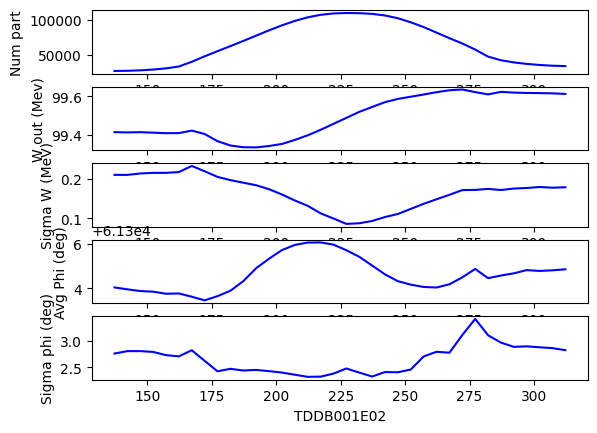

In [10]:
PLOT_INTERMEDIATE_RESULTS = False
try: #use try to allow graceful exit if simulation crashes, so that PV is restored to init val
#    plt.ion() #interactive mode ON
    if(PLOT_INTERMEDIATE_RESULTS):
        plot = hps.DistPlot(nrow=4, ncol=3, hsize=16, vsize=12)
    output = []
    bll = []
    firstpass = True

    for val in np.arange(PV_MIN, PV_MAX, PV_STEP):
        beam.restore_initial_beam()
        hps.set_db_epics(EPICS_PV, val)
        print( EPICS_PV, "is now", hps.get_db_epics(EPICS_PV) )
        
        # simulate here
        sim.simulate(SIM_START, SIM_STOP)
        
        wmask = beam.get_mask_with_limits('w',lolim=ENERGY_CUTOFF)
        mask = beam.get_good_mask(wmask)

        if len(mask) > 0:
            try:
                dist = hps.Distribution(beam, mask)
                # beam.print_results(mask)
                # save npart, avgW, sigW, avgPHI, sigPHI beam quantities to output list
                output.append([val, dist.get_size(), 
                               dist.get_avg('w'), \
                               dist.get_sig('w'), \
                               dist.get_avg('phi'), \
                               dist.get_sig('phi')])
                if(PLOT_INTERMEDIATE_RESULTS):
                    plot.clear()
                    # create intermediate results to plot for each scan step 
                    plot.iso_phase_space('xxp', dist, 1)
                    plot.iso_phase_space('yyp', dist, 2)
                    plot.iso_phase_space('phiw', dist, 3)
                    plot.hist2d_phase_space('xxp', dist, 4)
                    plot.hist2d_phase_space('yyp', dist, 5)
                    plot.hist2d_phase_space('phiw', dist, 6)
                    plot.profile('x', dist, 7, 'r-')
                    plot.profile('y', dist, 8, 'r-')
                    plot.profile('phi', dist, 9, 'r-')
                    plot.profile('xp', dist, 10, 'r-')
                    plot.profile('yp', dist, 11, 'r-')
                    plot.profile('w', dist, 12, 'r-')
                    title = "H{0} from {1} to {2}; {3} {4} = {5}".format(\
                        BEAM, SIM_START, SIM_STOP, PV_TYPE, EPICS_PV, val)
                    plot.title(title)
                    plot.draw()
                    if firstpass:
                        plt.draw()
                        plt.pause(0.1)
                        plt.show(block = False)
                        firstpass = False
                    else:
                        plt.draw()
                        plt.pause(0.1)

            except:
                print (" Warning - No output for PV at this value")
finally:
    plt.ioff()
    hps.set_db_epics(EPICS_PV, PV_INIT_VAL)
    print( '{0} restore to original value {1}'.format(EPICS_PV, PV_INIT_VAL) )

    # print results
    for item in output:
        print( item )

# plot output list quantities
    pv_val, npart, wout, sig_w, avg_phi, sig_phi = zip(*output)
        
    fig2 = plt.figure()
    title = "H{0} from {1} to {2}; scan of {3} {4}".format(\
        BEAM, SIM_START, SIM_STOP, PV_TYPE, EPICS_PV)
    fig2.canvas.set_window_title(title)
    
    a1 = fig2.add_subplot(511)
    a1.plot(pv_val, npart, 'b-')
    a1.set_ylabel('Num part')
    
    a2 = fig2.add_subplot(512)
    a2.plot(pv_val, wout, 'b-')
    a2.set_ylabel('W out (Mev)')
    
    a3 = fig2.add_subplot(513)
    a3.plot(pv_val, sig_w, 'b-')
    a3.set_ylabel('Sigma W (MeV)')
    
    a4 = fig2.add_subplot(514)
    a4.plot(pv_val, avg_phi, 'b-')
    a4.set_ylabel('Avg Phi (deg)')

    a5 = fig2.add_subplot(515)
    a5.plot(pv_val, sig_phi, 'b-')
    a5.set_ylabel('Sigma phi (deg)')    
    a5.set_xlabel(EPICS_PV)
    
    plt.show()